In [ ]:
import numpy as np
import random

MDP Environment model: <br />
TODO: separate transitions map creations from the model

In [ ]:
class MDPEnvironment:
    def __init__(self, terminalStates = list(), livingCost = 0.0, startState = "", n = 0, m = 0, states = [], actions = [], rewards = [], transitions = [], variables = [], transitionDependencies = [], variableTransitions = dict(), is_stochastic = False, p_slipping = 0.1, gamma=0.9, eps=1e-6):

        self.is_stochastic = is_stochastic
        self.p_slipping = p_slipping
        self.gamma = gamma
        self.eps = eps
        self.transitionDependencies = transitionDependencies
        self.variableTransitions = variableTransitions
        self.variables = variables
        self.terminalStates = terminalStates
        self.startState = startState
        self.livingCost = livingCost

        if (n != 0 and m != 0):
            self.InitializeGrid(n, m)

        elif (states != [] and actions != [] and rewards != [] and transitions != []):
            self.InitializeTransitions(states, actions, rewards, transitions)
            if (self.terminalStates == list()):
                self.terminalStates = self.FindTerminalStates()
            if (self.startState == ""):
                self.startState = list(self.states)[0]
        else:
            print ("Failed to initialize MDP! Verify your input")
            return


    def InitializeGrid(self, n, m):
        self.states = list()
        self.transitions = dict()
        self.rewards = dict()
        for i in range(n):
            for j in range(m):
                state = f"{i},{j}"
                self.states.append(state)

                transitionsRow = dict()
                rewardsRow = dict()
                if j < m - 1:
                    transitionsRow['e'] = {f"{i},{j+1}": 1.0}
                if j > 0:
                    transitionsRow['w'] = {f"{i},{j-1}": 1.0}
                if i > 0:
                    transitionsRow['n'] = {f"{i-1},{j}": 1.0}
                if i < n - 1:
                    transitionsRow['s'] = {f"{i+1},{j}": 1.0}

                self.transitions[state] = transitionsRow
                self.rewards[state] = {}  # Initialize rewards for each state

        for j in range(1, m-1):
            state = f"{n-1},{j}"
            self.SetStateRewards(state, -1)
            self.terminalStates.append(state)
        self.SetStateRewards(f"{n-1},{m-1}", 1)
        self.terminalStates.append(f"{n-1},{m-1}")
        self.terminalStates.append(f"{n-1},{0}")
        self.startState = f"{n-1},{0}"

    def SetStateRewards(self, state, reward):
        parentStates = self.GetParentStates(state)

        for parentState in parentStates:
            if parentState not in self.rewards:
                self.rewards[parentState] = {}

            possibleActions = self.transitions[parentState]

            for action in possibleActions:
                if (list(self.transitions[parentState][action])[0] == state):
                    if action not in self.rewards[parentState]:
                        self.rewards[parentState][action] = {}
                    self.rewards[parentState][action][state] = reward

    def InitializeTransitions(self, states, actions, rewards, transitions):
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.transitions = transitions


    def FindTerminalStates(self):
        terminalStates = set(self.states)
        for state in self.states:
            if (state in self.transitions.keys()):
                terminalStates.remove(state)
        return terminalStates

    def GetTransitions(self, state, action):
        return self.transitions[state][action]

    def GetReward(self, state, action, newState):
        if (state in self.rewards and action in self.rewards[state] and newState in self.rewards[state][action]):
            return self.rewards[state][action][newState]
        else:
            return 0

    def GetParentStates(self, targetState):
        #if slipped, move the agent to a random state, preceeding to the current one
        parentStates = []
        for state in self.states:
            for action in self.transitions.get(state, {}):
                if (targetState in self.transitions[state][action]):
                    parentStates.append(state)
        return parentStates


    def Slip(self, currentState):
        reachableStates = self.GetParentStates(currentState)
        if (reachableStates == []): #safeguard in case no states lead to the current state
            reachableStates.append(currentState)
        return np.random.choice(reachableStates)

    def GetActions(self, state):
        return set(self.transitions[state].keys())

    def UpdateVariables(self, state):
        for variableName in self.variableTransitions.keys():
            if (state in self.variableTransitions[variableName]):
                self.variables[variableName] = self.variableTransitions[variableName][state](self.variables[variableName])

    def VerifyTransitionDependencies(self, state, action):
        complies = True
        if (state in self.transitionDependencies and
            action in self.transitionDependencies[state]):
            for variable in self.transitionDependencies[state][action]:
                if (not self.transitionDependencies[state][action][variable](self.variables[variable])):
                    complies = False
        return complies

    def PerformAction(self, state, action):
        isTerminated = False
        possibilities = self.GetTransitions(state, action)

        if ((not action in self.GetActions(state)) or
            (not self.VerifyTransitionDependencies(state, action))
            ):#in case if the action is impossible, do nothing
            return (state, 0, isTerminated, self.variables)

        if (self.is_stochastic and (np.random.rand()<=self.p_slipping)):
            print ("You slipped!")
            newState = self.Slip(state)
            reward = 0
        else:
            newState = random.choices(list(possibilities.keys()), weights=list(possibilities.values()))[0]
            reward = self.GetReward(state, action, newState)

        reward -= self.livingCost
        self.UpdateVariables(newState)
        isTerminated = (newState in self.terminalStates)
        return (newState, reward, isTerminated, self.variables)

    def ConfigureStochasticity(self, is_stochastic, p_slipping = -1):
        self.is_stochastic = is_stochastic
        if (p_slipping >=0 and p_slipping < 1):
            self.p_slipping = p_slipping


MDP Test function:

In [ ]:
def TestMDP(MDP, state, action):
    newState, reward, isTerminated, variables = MDP.PerformAction(state, action)
    print (f"{state} -> {newState}, reward: {reward}, isTerminated: {isTerminated}\n variables: {variables}")


q-learning agent

In [ ]:
def q_learning(env, episodes, steps, alpha=0.1, gamma=0.9, epsilon= 0.2):
    q_table = {(state): {action: 0 for action in env.GetActions(state)} for state in env.states}
    rewPerEpis = []
    #Q = np.zeros([grid.griddy, len(grid.actions)])

    for a in range(episodes):
        state = env.startState
        totalRev = 0
        # In case the epsilon is high we can decrease it each episode, this way there will be a lot of exploring
        # in the beginning and next to non as the episode numbers increase
        epsilon = epsilon * 0.99
        for b in range(steps):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(list(env.GetActions(state)))
            else:
                action = max(q_table[state], key=q_table[state].get)

            newState, reward, isTerminated, variables = env.PerformAction(state, action) #slipping and cost of living are implemented within the environment

            # In case if the agent is terminated, but no positive reward is received, extra punishment is received, to further encite it to avoid termination zones
            if isTerminated and reward <= 0:
                reward -= 1

            q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * max(q_table[newState].values()) - q_table[state][action])

            #Update accumulated rewards for this episode
            totalRev += reward

            # Quit episode in case the new state is a terminal one
            if isTerminated:
                print(f"Episode {a + 1} finished in steps: {b + 1} with reward {totalRev}. The reward for the state {newState} was {reward}")
                break

            # Update the state for the next iteration
            state = newState

        rewPerEpis.append(totalRev)
    return q_table, rewPerEpis


# Example usage
env = MDPEnvironment(n = 3, m = 5)
env.livingCost = 0.01
q_table, rewPerEpis = q_learning(env, episodes=1000, steps=100)

Episode 1 finished in steps: 1 with reward -2.01. The reward for the state 2,1 was -2.01
Episode 2 finished in steps: 2 with reward -1.02. The reward for the state 2,0 was -1.01
Episode 3 finished in steps: 15 with reward -2.15. The reward for the state 2,1 was -2.01
Episode 4 finished in steps: 4 with reward -1.04. The reward for the state 2,0 was -1.01
Episode 5 finished in steps: 24 with reward -2.2399999999999998. The reward for the state 2,2 was -2.01
Episode 6 finished in steps: 27 with reward -2.27. The reward for the state 2,3 was -2.01
Episode 7 finished in steps: 4 with reward -1.04. The reward for the state 2,0 was -1.01
Episode 8 finished in steps: 20 with reward 0.7999999999999999. The reward for the state 2,4 was 0.99
Episode 9 finished in steps: 10 with reward 0.9. The reward for the state 2,4 was 0.99
Episode 10 finished in steps: 13 with reward -2.13. The reward for the state 2,1 was -2.01
Episode 11 finished in steps: 12 with reward 0.88. The reward for the state 2,4 

Plotting:

State: 0,0
  Action: s, Q-value: 0.04565760718081143
  Action: e, Q-value: -0.010821527595395251

State: 0,1
  Action: w, Q-value: -0.008692881611864519
  Action: e, Q-value: -0.008863488261101522
  Action: s, Q-value: 0.25985834234501237

State: 0,2
  Action: w, Q-value: -0.006453201259697948
  Action: e, Q-value: -0.00531019
  Action: s, Q-value: 0.07663464113074432

State: 0,3
  Action: w, Q-value: -0.0029701
  Action: e, Q-value: -0.003529
  Action: s, Q-value: 0.20721549959116226

State: 0,4
  Action: w, Q-value: -0.00317070176581
  Action: s, Q-value: 0.39344917613499564

State: 1,0
  Action: s, Q-value: -0.5398963144344208
  Action: e, Q-value: 0.6151489999999982
  Action: n, Q-value: -0.013798916008386283

State: 1,1
  Action: w, Q-value: 0.0834725398263513
  Action: e, Q-value: 0.6946099999999984
  Action: n, Q-value: 0.04069750595932335
  Action: s, Q-value: -1.048623231

State: 1,2
  Action: w, Q-value: 0.12329173930225826
  Action: e, Q-value: 0.7828999999999988
  Action: n

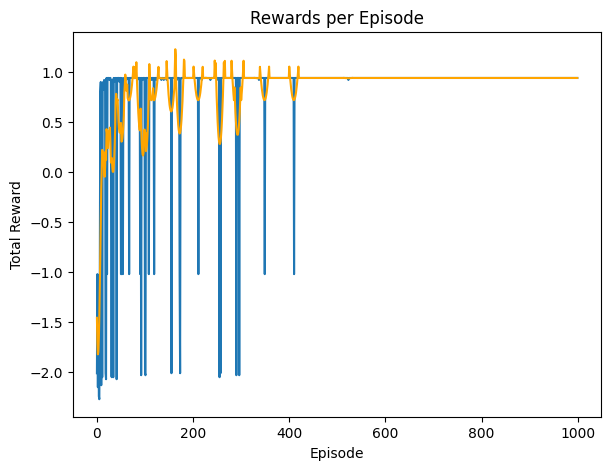

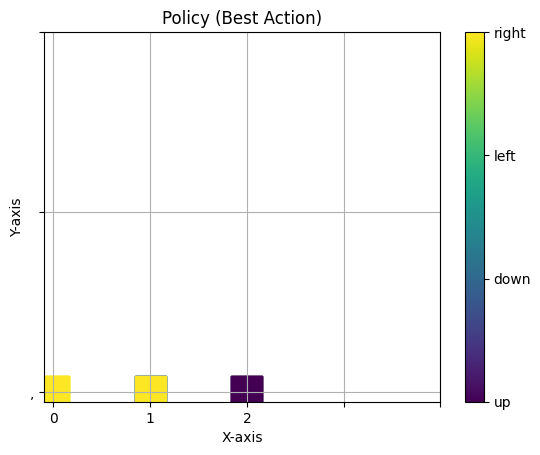

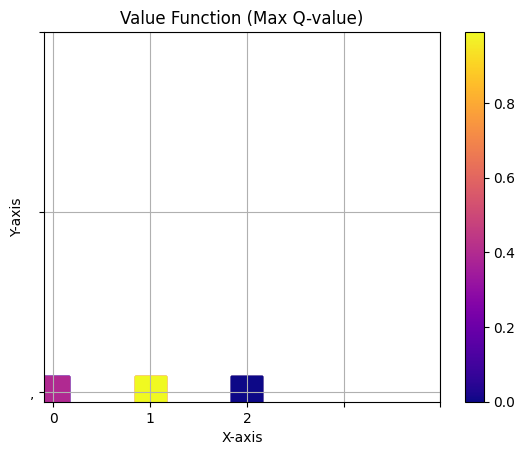

In [ ]:
MOVING = True # extra cleaner plot with moving-average of reward
if MOVING:
    from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def print_q_table(q_table):
    for state, actions in q_table.items():
        print(f"State: {state}")
        for action, value in actions.items():
            print(f"  Action: {action}, Q-value: {value}")
        print("")

# Print the learned Q-table
print_q_table(q_table)

# Moving averge
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(rewPerEpis, label='Total Reward')
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

if MOVING:
    moving_average_window = 20
    moving_averages = savgol_filter(rewPerEpis, moving_average_window, 3)
    plt.plot(moving_averages, label=f'Moving Average (Window {moving_average_window})', color='orange')

plt.show()

def get_policy_value(q_table):
    policy = {}
    value = {}
    for state, actions in q_table.items():
        best_action = max(actions, key=actions.get)
        policy[state] = best_action
        value[state] = actions[best_action]
    return policy, value

# Retrieve policy and value from the learned Q-table
policy, value = get_policy_value(q_table)

# Plotting the policy with categorical colors assigned to actions and annotations
def plot_policy(policy):
    x = [state[0] for state in policy.keys()]
    y = [state[1] for state in policy.keys()]
    actions = list(policy.values())

    # Map actions to numerical values
    action_to_value = {'w': 1, 'e': 2, 'n': 3, 's': 4}
    values = [action_to_value[action] for action in actions]

    fig, ax = plt.subplots()
    ax.set_title('Policy (Best Action)')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Scatter plot with numerical values
    sc = ax.scatter(x, y, c=values, cmap='viridis', s=500, marker='s')

    # Create a colorbar with action annotations
    cbar = plt.colorbar(sc, ticks=[1, 2, 3, 4])
    cbar.ax.set_yticklabels(['up', 'down', 'left', 'right'])

    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(0, 3, 1))
    plt.grid(visible=True)
    plt.show()

# Plotting the value function
def plot_value_function(value):
    x = [state[0] for state in value.keys()]
    y = [state[1] for state in value.keys()]
    values = list(value.values())

    fig, ax = plt.subplots()
    ax.set_title('Value Function (Max Q-value)')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    sc = ax.scatter(x, y, c=values, cmap='plasma', s=500, marker='s')
    plt.colorbar(sc)
    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(0, 3, 1))
    plt.grid(visible=True)
    plt.show()

# Plotting policy and value function
plot_policy(policy)
plot_value_function(value)
